# Mini-Projet — Apprentissage Supervisé Linéaire
**Étudiant :** C34645 — Zahra Yeselk Boubacar

**Encadrant :** Dr. EL BENANY Mohamed Mahmoud  




In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


## 1) Fonctions utilitaires (métriques + normalisation)


### Évaluation (classification)

- **Matrice de confusion** : compte VP / VN / FP / FN  

- **Accuracy** :
$$
\frac{VP + VN}{VP + VN + FP + FN}
$$

- **Precision** :
$$
\frac{VP}{VP + FP}
$$

- **Recall** :
$$
\frac{VP}{VP + FN}
$$

- **F1-score** :
$$
2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
$$

**Objectif :** analyser le type d’erreurs (**FP vs FN**), pas seulement un score global.


In [2]:
def train_test_split_numpy(X, y, test_size=0.2, random_state=42):
    rng = np.random.default_rng(random_state)
    idx = np.arange(X.shape[0])
    rng.shuffle(idx)
    split = int(X.shape[0] * (1 - test_size))
    train_idx, test_idx = idx[:split], idx[split:]
    return X[train_idx], X[test_idx], y[train_idx], y[test_idx]

def standardize_fit(X):
    mu = X.mean(axis=0, keepdims=True)
    sigma = X.std(axis=0, keepdims=True)
    sigma[sigma == 0] = 1.0
    return mu, sigma

def standardize_transform(X, mu, sigma):
    return (X - mu) / sigma

# ---------- Régression : MSE et R2 ----------
def mse(y_true, y_pred):
    y_true = y_true.reshape(-1, 1)
    y_pred = y_pred.reshape(-1, 1)
    return float(np.mean((y_true - y_pred) ** 2))

def r2_score(y_true, y_pred):
    y_true = y_true.reshape(-1, 1)
    y_pred = y_pred.reshape(-1, 1)
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return float(1 - ss_res / ss_tot) if ss_tot != 0 else 0.0

# ---------- Classification : confusion matrix, accuracy, precision, recall ----------
def confusion_matrix_binary(y_true, y_pred):
    y_true = y_true.astype(int).ravel()
    y_pred = y_pred.astype(int).ravel()
    tp = int(np.sum((y_true == 1) & (y_pred == 1)))
    tn = int(np.sum((y_true == 0) & (y_pred == 0)))
    fp = int(np.sum((y_true == 0) & (y_pred == 1)))
    fn = int(np.sum((y_true == 1) & (y_pred == 0)))
    return np.array([[tn, fp],
                     [fn, tp]])

def accuracy(y_true, y_pred):
    y_true = y_true.astype(int).ravel()
    y_pred = y_pred.astype(int).ravel()
    return float(np.mean(y_true == y_pred))

def precision(y_true, y_pred):
    cm = confusion_matrix_binary(y_true, y_pred)
    tp = cm[1, 1]
    fp = cm[0, 1]
    return float(tp / (tp + fp)) if (tp + fp) != 0 else 0.0

def recall(y_true, y_pred):
    cm = confusion_matrix_binary(y_true, y_pred)
    tp = cm[1, 1]
    fn = cm[1, 0]
    return float(tp / (tp + fn)) if (tp + fn) != 0 else 0.0


# Partie 1 — Régression Linéaire
prédire une variable continue


In [4]:
# --- Option Colab : upload du fichier ---
# from google.colab import files
# files.upload()

# ⚠️ Assure-toi que le fichier est bien dans le même dossier que ce notebook.
df = pd.read_csv("insurance.csv")
df.head()


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## 1.2 Prétraitement


In [5]:
# Vérification rapide
print(df.info())
print(df.isna().sum())

# Séparation X / y
y = df["charges"].values.reshape(-1, 1)
X_df = df.drop(columns=["charges"])

# One-Hot Encoding (prétraitement, pas un modèle)
X_df = pd.get_dummies(X_df, drop_first=True)

# Conversion en numpy
X = X_df.values.astype(float)

# Standardisation (optionnel pour linéaire, mais aide la descente de gradient)
mu_X, sigma_X = standardize_fit(X)
X_std = standardize_transform(X, mu_X, sigma_X)

# Ajout biais (colonne de 1)
X_std_b = np.hstack([np.ones((X_std.shape[0], 1)), X_std])

print("X shape:", X_std_b.shape, " | y shape:", y.shape)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
None
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64
X shape: (1338, 9)  | y shape: (1338, 1)


## 1.3 Heatmap des corrélations
La corrélation se calcule sur les variables numériques

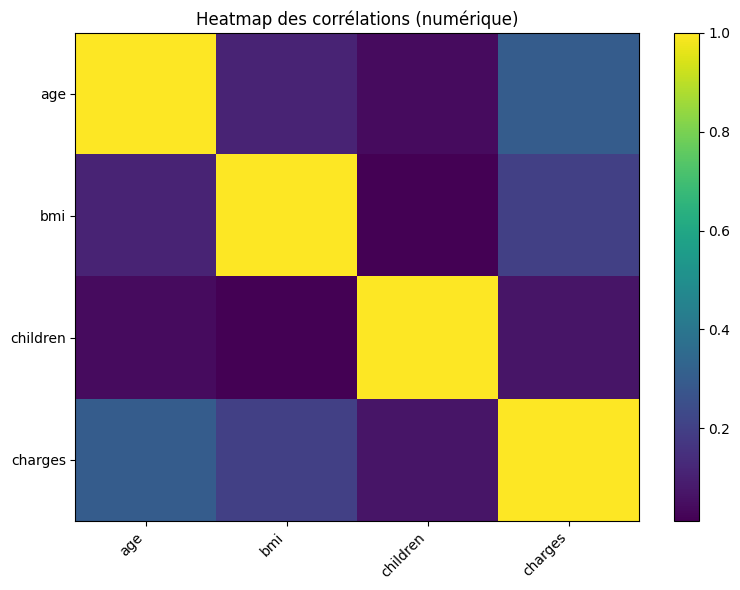

In [6]:
num_cols = df.select_dtypes(include=["int64", "float64"]).columns
corr = df[num_cols].corr()

plt.figure(figsize=(8, 6))
plt.imshow(corr, aspect="auto")
plt.xticks(range(len(num_cols)), num_cols, rotation=45, ha="right")
plt.yticks(range(len(num_cols)), num_cols)
plt.colorbar()
plt.title("Heatmap des corrélations (numérique)")
plt.tight_layout()
plt.show()


## 1.4 Descente de gradient

Fonction coût (MSE) :  


### Méthode : Régression linéaire (Batch Gradient Descent)

**Modèle :**  
\[
\hat{y}=X\theta
\]

**Fonction de coût (MSE) :**  
\[
J(\theta)=\frac{1}{2m}\sum_{i=1}^{m}(\hat{y}_i-y_i)^2
\]

**Mise à jour (descente de gradient) :**  
\[
\theta := \theta - \alpha \cdot \frac{1}{m}X^T(\hat{y}-y)
\]

**Étapes :**
- calculer \(\hat{y}\)
- calculer l’erreur \((\hat{y}-y)\)
- calculer le gradient
- mettre à jour \(\theta\)
- répéter **600 itérations**

In [ ]:
def predict_linear(X, theta):
    return X @ theta

def compute_cost_linear(X, y, theta):
    m = X.shape[0]
    y_pred = predict_linear(X, theta)
    return float((1/(2*m)) * np.sum((y_pred - y) ** 2))

def gradient_descent_linear(X, y, theta, alpha=0.05, iterations=600):
    m = X.shape[0]
    history = []
    for it in range(iterations):
        y_pred = predict_linear(X, theta)
        grad = (1/m) * (X.T @ (y_pred - y))
        theta = theta - alpha * grad
        if it % 100 == 0:
            history.append(compute_cost_linear(X, y, theta))
    return theta, history

# Split train/test
X_train, X_test, y_train, y_test = train_test_split_numpy(X_std_b, y, test_size=0.2, random_state=42)

# Entraînement
theta0 = np.zeros((X_train.shape[1], 1))
theta, cost_hist = gradient_descent_linear(X_train, y_train, theta0, alpha=0.05, iterations=600)

print("Dernier coût (échantillonné):", cost_hist[-1] if cost_hist else compute_cost_linear(X_train, y_train, theta))


Dernier coût (échantillonné): 18657298.944291744


## 1.5 Évaluation (from scratch)
- MSE
- \(R^2\)
- Graphique Réel vs Prédit

MSE = 33570123.21439599
R²  = 0.790346090709198


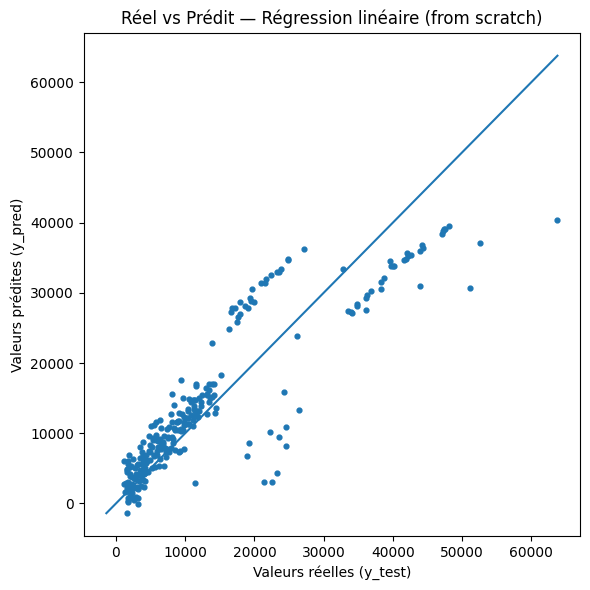

In [8]:
# Prédictions
y_pred_test = predict_linear(X_test, theta)

# Métriques
print("MSE =", mse(y_test, y_pred_test))
print("R²  =", r2_score(y_test, y_pred_test))

# Réel vs Prédit
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_test, s=12)
plt.xlabel("Valeurs réelles (y_test)")
plt.ylabel("Valeurs prédites (y_pred)")
plt.title("Réel vs Prédit — Régression linéaire (from scratch)")
mmin = min(y_test.min(), y_pred_test.min())
mmax = max(y_test.max(), y_pred_test.max())
plt.plot([mmin, mmax], [mmin, mmax])
plt.tight_layout()
plt.show()


## 1.6 Interprétation des coefficients (top impact)


,Feature,Coefficient
0,bias,13364.722895
5,smoker_yes,9505.853687
1,age,3591.726744
2,bmi,2075.019238
3,children,674.221235
4,sex_male,-0.748697
6,region_northwest,-199.460126
8,region_southwest,-534.822863
7,region_southeast,-644.741914


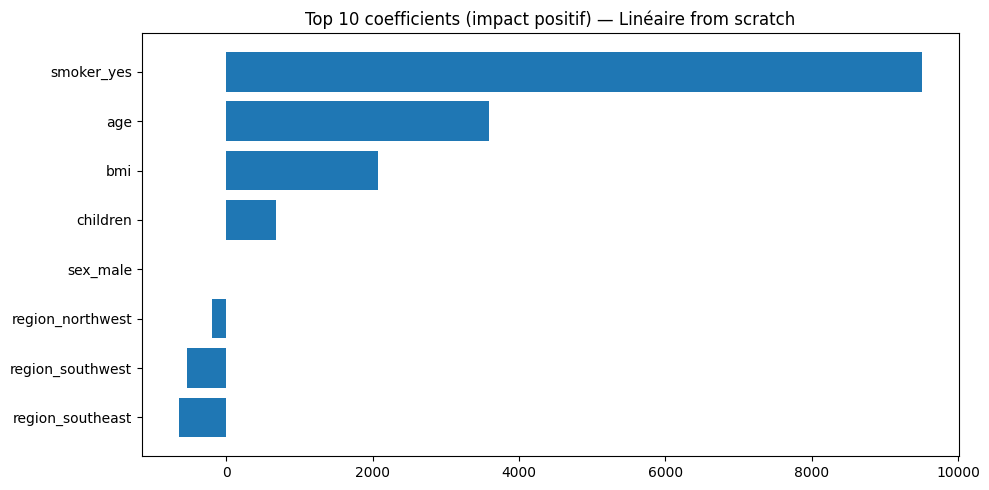

In [9]:
feature_names = ["bias"] + list(X_df.columns)
coef = theta.ravel()

coef_df = pd.DataFrame({"Feature": feature_names, "Coefficient": coef}).sort_values("Coefficient", ascending=False)
display(coef_df.head(12))

# Top 10 positifs (sans bias)
top_pos = coef_df[coef_df["Feature"]!="bias"].head(10)
plt.figure(figsize=(10,5))
plt.barh(top_pos["Feature"][::-1], top_pos["Coefficient"][::-1])
plt.title("Top 10 coefficients (impact positif) — Linéaire from scratch")
plt.tight_layout()
plt.show()


# Partie 2 — Régression Logistique




In [10]:
# Dataset Iris
from sklearn.datasets import load_iris

iris = load_iris()
X = iris.data.astype(float)
y = iris.target

# Binaire : setosa = 1, autres = 0
y_bin = (y == 0).astype(int).reshape(-1, 1)

# Standardisation
mu, sigma = standardize_fit(X)
X_std = standardize_transform(X, mu, sigma)

# Ajout biais
X_b = np.hstack([np.ones((X_std.shape[0], 1)), X_std])

# Split train/test
X_train, X_test, y_train, y_test = train_test_split_numpy(X_b, y_bin, test_size=0.2, random_state=42)
print("Shapes:", X_train.shape, X_test.shape, y_train.shape, y_test.shape)


Shapes: (120, 5) (30, 5) (120, 1) (30, 1)


## 2.1 Modèle logistique


### Méthode : Régression logistique (Batch Gradient Descent)

**Sigmoïde :**

$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$

**Probabilité :**

$$
p = \sigma(X\theta)
$$

**Fonction de coût (Log-Loss) :**

$$
J(\theta) = -\frac{1}{m}\sum_{i=1}^{m}
\left[
y_i \log(p_i) + (1 - y_i)\log(1 - p_i)
\right]
$$

**Mise à jour :**

$$
\theta := \theta - \alpha \cdot \frac{1}{m} X^T (p - y)
$$

**Étapes :**
- calculer \(p\)
- calculer \(p - y\)
- calculer le gradient
- mettre à jour \(\theta\)
- répéter **600 itérations**


In [ ]:
def sigmoid(z):
    # clip pour éviter overflow
    z = np.clip(z, -500, 500)
    return 1.0 / (1.0 + np.exp(-z))

def predict_proba_logistic(X, theta):
    return sigmoid(X @ theta)

def compute_cost_logistic(X, y, theta):
    m = X.shape[0]
    p = predict_proba_logistic(X, theta)
    eps = 1e-9
    return float((-1/m) * np.sum(y*np.log(p+eps) + (1-y)*np.log(1-p+eps)))

def gradient_descent_logistic(X, y, theta, alpha=0.1, iterations=600):
    m = X.shape[0]
    history = []
    for it in range(iterations):
        p = predict_proba_logistic(X, theta)
        grad = (1/m) * (X.T @ (p - y))
        theta = theta - alpha * grad
        if it % 100 == 0:
            history.append(compute_cost_logistic(X, y, theta))
    return theta, history

# Entraînement
theta0 = np.zeros((X_train.shape[1], 1))
theta, hist = gradient_descent_logistic(X_train, y_train, theta0, alpha=0.2, iterations=600)

print("Dernier coût (échantillonné):", hist[-1] if hist else compute_cost_logistic(X_train, y_train, theta))


Dernier coût (échantillonné): 0.0020716757358606626


## 2.2 Prédiction + métriques
- Matrice de confusion
- Accuracy, Precision, Recall

In [12]:
# Probabilités et classes
proba = predict_proba_logistic(X_test, theta)
y_pred = (proba >= 0.5).astype(int)

cm = confusion_matrix_binary(y_test, y_pred)
print("Matrice de confusion (binaire) :")
print(cm)

print("Accuracy  =", accuracy(y_test, y_pred))
print("Precision =", precision(y_test, y_pred))
print("Recall    =", recall(y_test, y_pred))


Matrice de confusion (binaire) :
[[17  0]
 [ 0 13]]
Accuracy  = 1.0
Precision = 1.0
Recall    = 1.0


## 2.3 Visualisation simple de la matrice de confusion

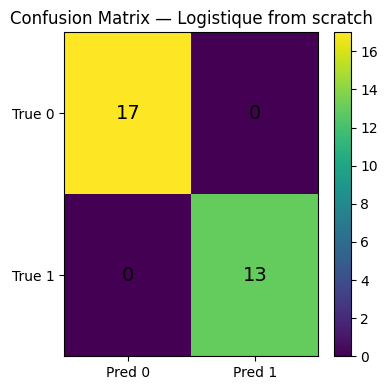

In [13]:
plt.figure(figsize=(4,4))
plt.imshow(cm, aspect="auto")
plt.xticks([0,1], ["Pred 0", "Pred 1"])
plt.yticks([0,1], ["True 0", "True 1"])
for (i,j), v in np.ndenumerate(cm):
    plt.text(j, i, str(v), ha="center", va="center", fontsize=14)
plt.title("Confusion Matrix — Logistique from scratch")
plt.colorbar()
plt.tight_layout()
plt.show()
